In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import math
import keras_tuner as kt

In [ ]:
# Load dataset
file_path = "data fixx.xlsx"  # Ganti dengan path file Anda
df = pd.read_excel(file_path, sheet_name="Sheet1")

df.head()

,Tahun,Bulan,Pintu Udara,Pintu Laut,Pintu Darat
0,2008,1,270189,89296,1043
1,2008,2,294147,102762,1613
2,2008,3,312324,108215,1610
3,2008,4,285113,93401,1234
4,2008,5,321657,105042,1606


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Tahun        204 non-null    int64
 1   Bulan        204 non-null    int64
 2   Pintu Udara  204 non-null    int64
 3   Pintu Laut   204 non-null    int64
 4   Pintu Darat  204 non-null    int64
dtypes: int64(5)
memory usage: 8.1 KB


In [ ]:
df.isnull().sum()

Tahun          0
Bulan          0
Pintu Udara    0
Pintu Laut     0
Pintu Darat    0
dtype: int64

In [ ]:
# Bersihkan nama kolom dari spasi tambahan
df.rename(columns=lambda x: x.strip(), inplace=True)

# Pastikan kolom Tahun dan Bulan bertipe numerik
df['Tahun'] = pd.to_numeric(df['Tahun'], errors='coerce')
df['Bulan'] = pd.to_numeric(df['Bulan'], errors='coerce')

# Buat kolom 'Tanggal' dengan cara alternatif
df['Tanggal'] = df.apply(lambda row: pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=1), axis=1)

# Atur indeks menjadi kolom Tanggal
df.set_index('Tanggal', inplace=True)
df.drop(columns=['Tahun', 'Bulan'], inplace=True)

df.head()

,Pintu Udara,Pintu Laut,Pintu Darat
Tanggal,,,
2008-01-01,270189,89296,1043
2008-02-01,294147,102762,1613
2008-03-01,312324,108215,1610
2008-04-01,285113,93401,1234
2008-05-01,321657,105042,1606


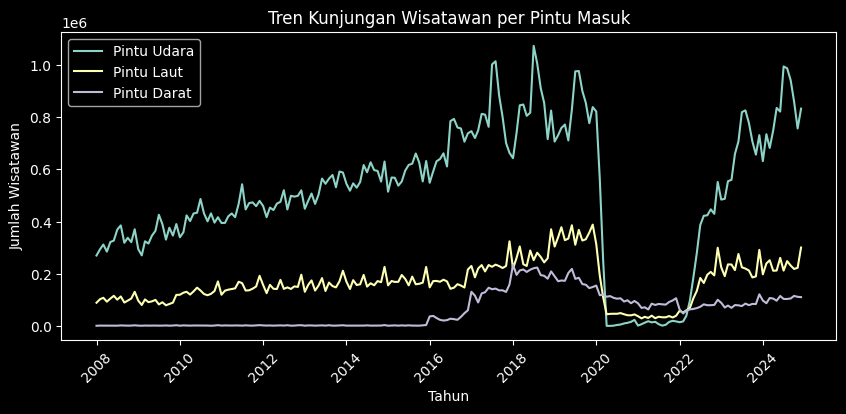

In [ ]:
# Plot data historis untuk setiap pintu masuk
plt.figure(figsize=(10, 4))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.legend()
plt.title("Tren Kunjungan Wisatawan per Pintu Masuk")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Wisatawan")
plt.xticks(rotation=45)
plt.show()

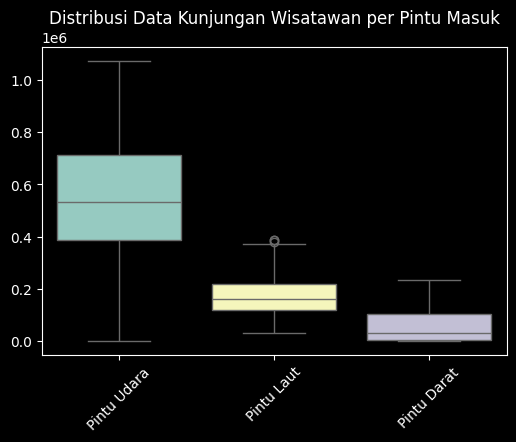

In [ ]:
# Boxplot untuk melihat outlier
plt.figure(figsize=(6,4))
sns.boxplot(data=df)
plt.title("Distribusi Data Kunjungan Wisatawan per Pintu Masuk")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Deteksi Outlier menggunakan IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
print("\nOutlier Data per Pintu Masuk:")
print(df[outliers].dropna(how='all'))


Outlier Data per Pintu Masuk:
            Pintu Udara  Pintu Laut  Pintu Darat
Tanggal                                         
2019-03-01          NaN    378698.0          NaN
2019-06-01          NaN    386152.0          NaN
2019-12-01          NaN    388495.0          NaN


In [ ]:
# Mengatasi outlier dengan mengganti nilai outlier dengan median
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = df[col].median()
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])

In [ ]:
# Normalisasi data per kolom
scalers = {}
df_scaled = df.copy()

for col in df.columns:
    scalers[col] = MinMaxScaler()
    df_scaled[[col]] = scalers[col].fit_transform(df[[col]])

In [ ]:
# Membuat sequence untuk LSTM
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [ ]:
# Hyperparameter tuning
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True, input_shape=(12, 1)),
        Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)),
        LSTM(hp.Int('units_2', min_value=32, max_value=128, step=32), return_sequences=False),
        Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='mse'
    )
    return model

Tuning model for Pintu Udara...
Reloading Tuner from tuner_results\tuning_Pintu Udara\tuner0.json


d:\Kerjaan\Prediksi kunjungan wisatawan\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - loss: 0.2430 - val_loss: 0.1067
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0632 - val_loss: 0.0975
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0401 - val_loss: 0.1142
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0470 - val_loss: 0.0736
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0141 - val_loss: 0.0688
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0286 - val_loss: 0.0699
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0364 - val_loss: 0.0660
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0324 - val_loss: 0.0622
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0173 - val_loss: 0.0637
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0207 - val_loss: 0.0687
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0216 - val_loss: 0.0682
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0

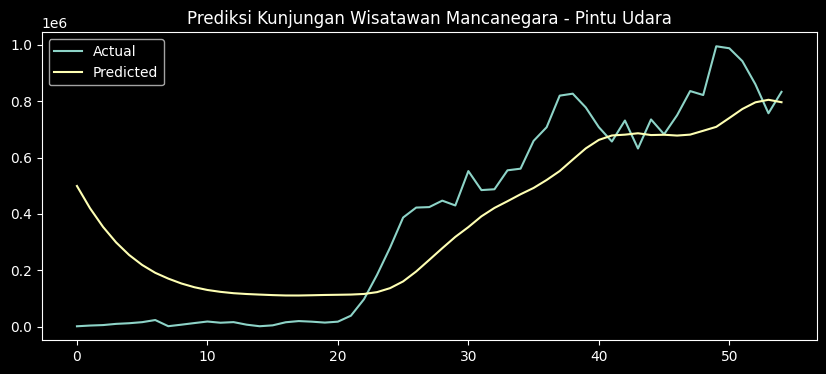

Tuning model for Pintu Laut...
Reloading Tuner from tuner_results\tuning_Pintu Laut\tuner0.json
Epoch 1/100


d:\Kerjaan\Prediksi kunjungan wisatawan\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - loss: 0.1990 - val_loss: 0.0852
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0646 - val_loss: 0.0752
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0358 - val_loss: 0.0915
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0485 - val_loss: 0.0534
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0269 - val_loss: 0.0498
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0344 - val_loss: 0.0500
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0389 - val_loss: 0.0462
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0286 - val_loss: 0.0451
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0280 - val_loss: 0.0492
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0244 - val_loss: 0.0508
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0244 - val_loss: 0.0469
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0265 - val_lo

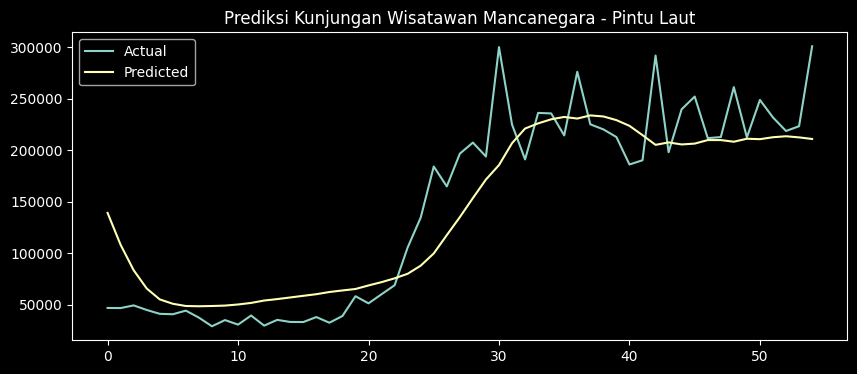

Tuning model for Pintu Darat...
Reloading Tuner from tuner_results\tuning_Pintu Darat\tuner0.json
Epoch 1/100


d:\Kerjaan\Prediksi kunjungan wisatawan\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - loss: 0.1774 - val_loss: 0.0819
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1121 - val_loss: 0.0229
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0496 - val_loss: 0.0160
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0337 - val_loss: 0.0743
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0449 - val_loss: 0.0446
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0304 - val_loss: 0.0117
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0265 - val_loss: 0.0064
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0253 - val_loss: 0.0076
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0254 - val_loss: 0.0069
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0245 - val_loss: 0.0062
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0225 - val_loss: 0.0105
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0171 - val_lo

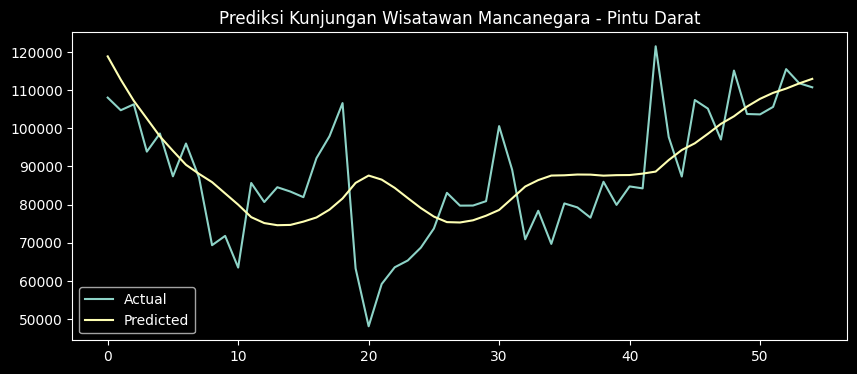

In [ ]:
# Tuning untuk setiap pintu masuk
best_models = {}
rmse_results = {}
r2_results = {}

for col in df_scaled.columns:
    print(f"Tuning model for {col}...")
    data = df_scaled[[col]].values
    X, y = create_sequences(data, seq_length=24)
    train_size = int(len(X) * 0.7)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    tuner = kt.BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='tuner_results',
        project_name=f'tuning_{col}'
    )

    tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)

    # Tambahkan Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    best_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping]  # Tambahkan di sini
    )
    best_models[col] = best_model

    # Evaluasi Model untuk tiap pintu masuk
    y_pred = best_model.predict(X_test)
    y_pred_rescaled = scalers[col].inverse_transform(y_pred)
    y_test_rescaled = scalers[col].inverse_transform(y_test)

    rmse = math.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    rmse_results[col] = rmse
    r2_results[col] = r2

    print(f'RMSE for {col}: {rmse}')
    print(f'R² for {col}: {r2}')

    # Plot hasil prediksi per pintu masuk
    plt.figure(figsize=(10,4))
    plt.plot(y_test_rescaled, label='Actual')
    plt.plot(y_pred_rescaled, label='Predicted')
    plt.legend()
    plt.title(f"Prediksi Kunjungan Wisatawan Mancanegara - {col}")
    plt.show()

In [ ]:
# Print semua hasil RMSE dan R²
print("\nRingkasan Evaluasi Model per Pintu Masuk:")
for col in rmse_results:
    print(f'{col}: RMSE = {rmse_results[col]}, R² = {r2_results[col]}')


Ringkasan Evaluasi Model per Pintu Masuk:
Pintu Udara: RMSE = 173869.22248314254, R² = 0.7526669346259109
Pintu Laut: RMSE = 38722.07865050986, R² = 0.8265267593701097
Pintu Darat: RMSE = 13013.520270395438, R² = 0.3589032475982987
